In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("7postElection.json")
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores


In [3]:
#prova a togliere retweet
data = data[data["is_retweet"] == False]

data.rename(index=str, columns={"year": "date_year"},inplace=True)
data.rename(index=str, columns={"month": "date_month"},inplace=True)

data.drop(["hour","in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,date_month,date_year,week_year,labels,vaderScore
favorite_count,1.000000,0.891237,-0.164023,0.185635,-0.164811,0.076417,-0.098971
retweet_count,0.891237,1.000000,-0.089613,0.144045,-0.090638,0.090506,-0.166127
date_month,-0.164023,-0.089613,1.000000,-0.302847,0.984279,-0.032168,0.064430
date_year,0.185635,0.144045,-0.302847,1.000000,-0.302369,0.021680,-0.019233
week_year,-0.164811,-0.090638,0.984279,-0.302369,1.000000,-0.034066,0.066510
labels,0.076417,0.090506,-0.032168,0.021680,-0.034066,1.000000,-0.129911
vaderScore,-0.098971,-0.166127,0.064430,-0.019233,0.066510,-0.129911,1.000000


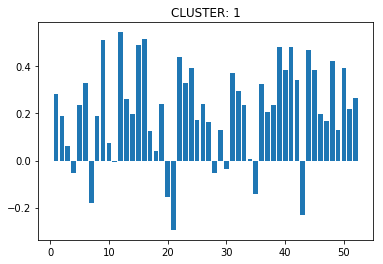

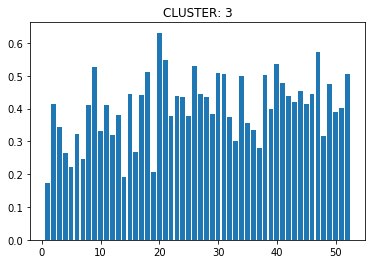

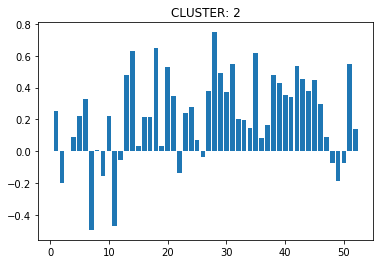

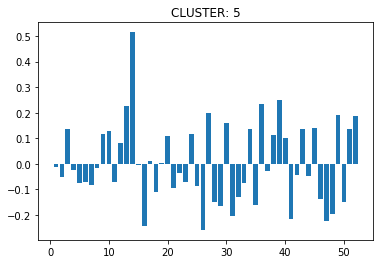

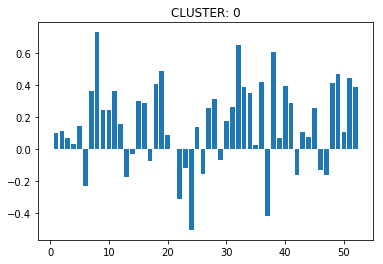

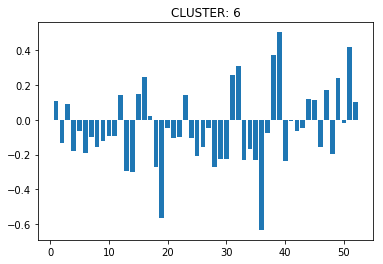

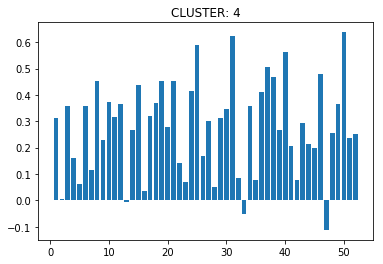

In [4]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()


In [5]:
x1 = data[data["labels"] == 6]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  

stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

687


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.663e+03, 6.400e+01, 2.000e+01, 1.200e+01, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   4. ,  150.7,  297.4,  444.1,  590.8,  737.5,  884.2, 1030.9,
        1177.6, 1324.3, 1471. ]),
 <a list of 10 Patch objects>)

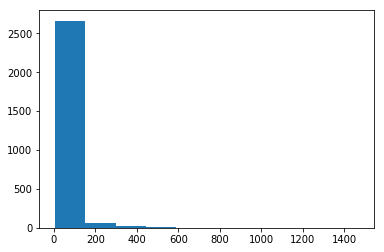

In [6]:
plt.hist(stemmed_words)

In [7]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!! sembra che il tempo peggiori sse e migliori silhouette
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
#dataWithText = res
res1.columns

Index(['date_year', 'week_year', 'vaderScore', '10', '100', '11', '116', '12',
       '12th', '13',
       ...
       'ye', 'year', 'yearli', 'yesterday', 'yet', 'york', 'young', 'zealand',
       'zero', 'zte'],
      dtype='object', length=1885)

# Hierarchical

In [8]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

sil = []
for c in range(10,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

10 0.625586895980668
11 0.5875662500835043
12 0.5808840841427424
13 0.572091753405523
14 0.5605009581504697
15 0.5419981133300311
16 0.5232681040948216
17 0.5078651849055341
18 0.500162414215829
19 0.4865051143119495
20 0.4774980032719283
21 0.44791371995412016


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(res1, 'average', "cosine")


In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()


In [9]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=15) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

Index(['date_year', 'week_year', 'vaderScore', '10', '100', '11', '116', '12',
       '12th', '13',
       ...
       'ye', 'year', 'yearli', 'yesterday', 'yet', 'york', 'young', 'zealand',
       'zero', 'zte'],
      dtype='object', length=1885)
0.5419981133300311


# LDA

In [10]:
res1["labels"] = labels
dataWithText["labels"] = labels
g = res1.drop(["vaderScore"],axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  10  lunghezza  70
NUMBER OF TOPICS FOR CLUSTER  10  :  7
2019    32
2018    23
2017    15
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3
[1, 2, 3]
numero di settimane in cluster 3


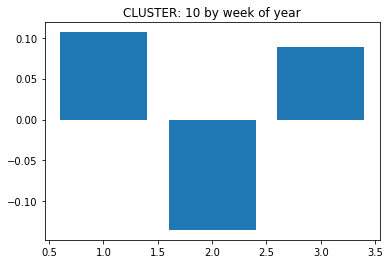

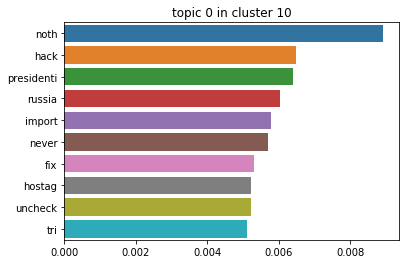

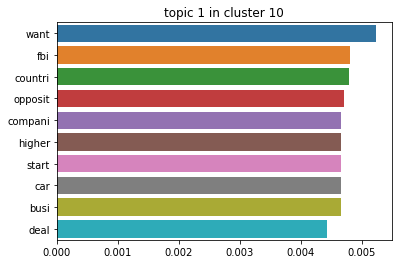

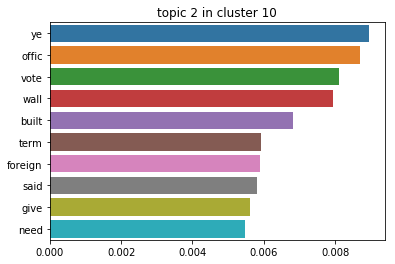

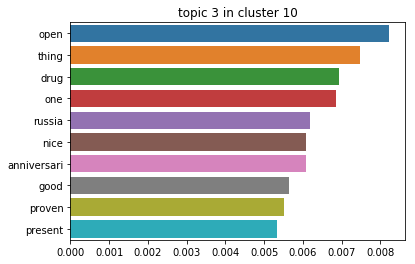

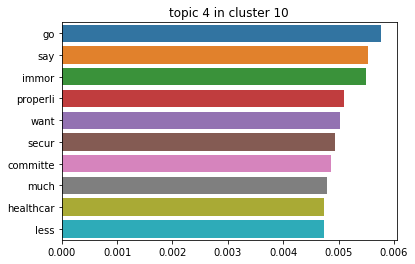

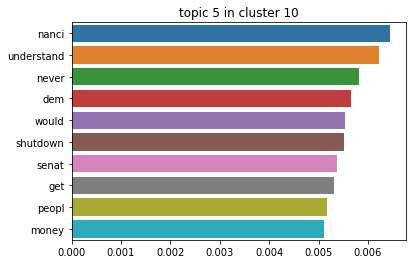

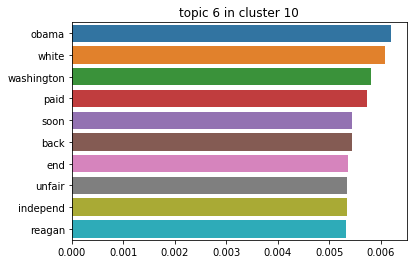

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


topics_count [20, 11, 11, 9, 7, 7, 5]


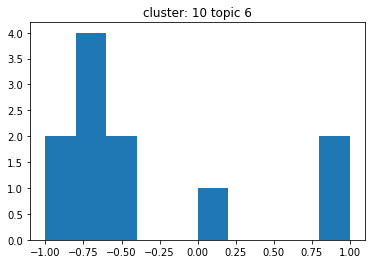

topic 6 [2017, 2018, 2019]


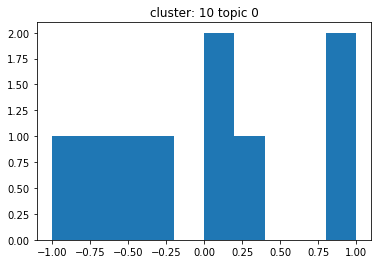

topic 0 [2017, 2018, 2019]


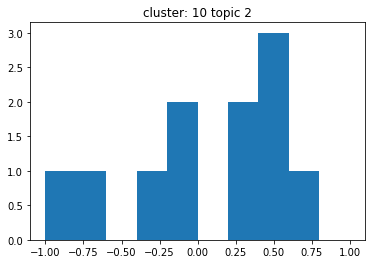

topic 2 [2017, 2018, 2019]


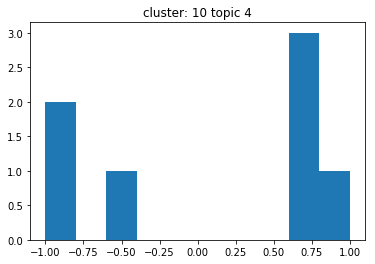

topic 4 [2017, 2018, 2019]


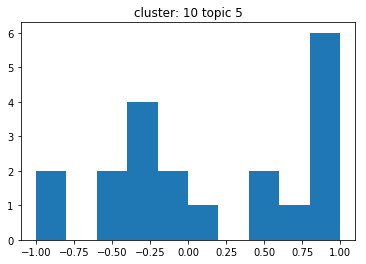

topic 5 [2017, 2018, 2019]


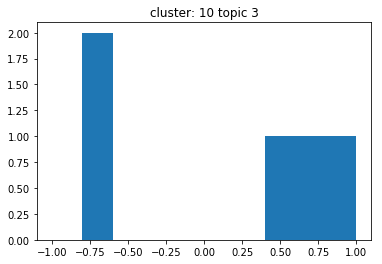

topic 3 [2017, 2018, 2019]


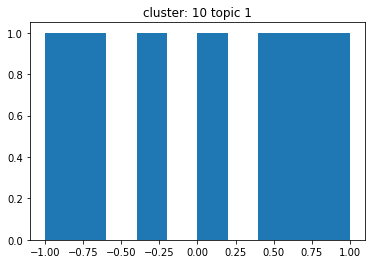

topic 1 [2017, 2018, 2019]
cluster  9  lunghezza  73
NUMBER OF TOPICS FOR CLUSTER  9  :  7
2019    31
2018    24
2017    18
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3
[4, 5, 6, 7]
numero di settimane in cluster 4


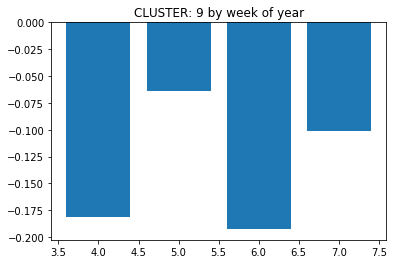

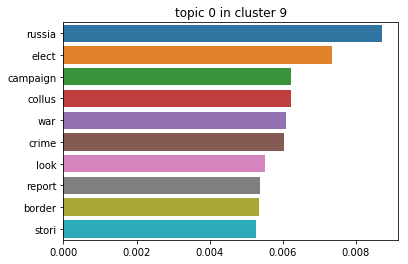

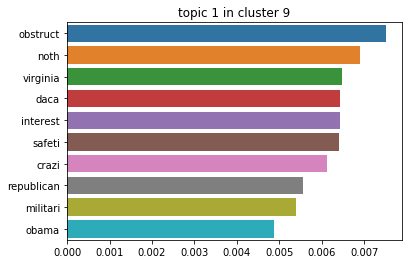

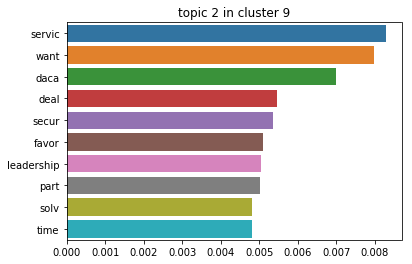

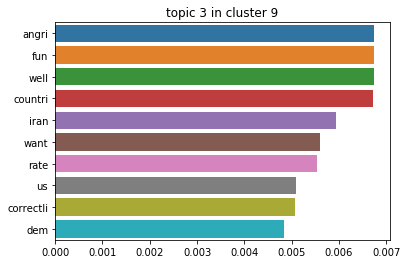

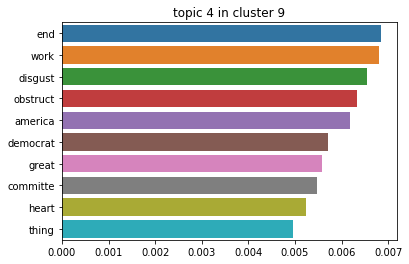

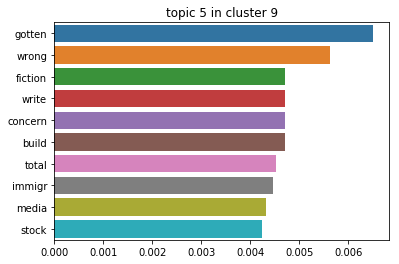

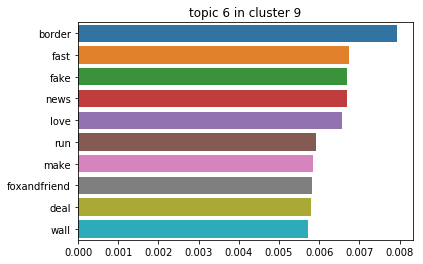

topics_count [15, 13, 13, 11, 9, 7, 5]


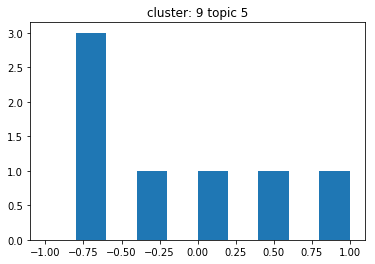

topic 5 [2017, 2018, 2019]


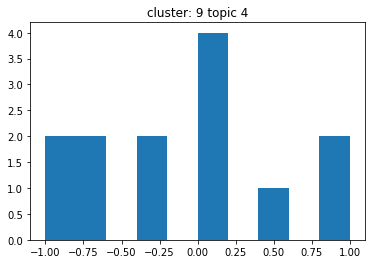

topic 4 [2017, 2018, 2019]


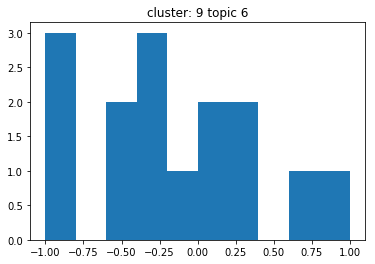

topic 6 [2017, 2018, 2019]


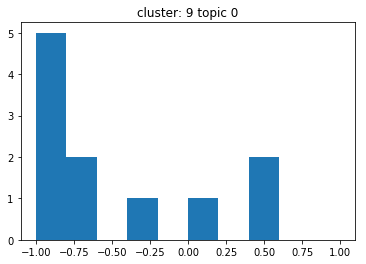

topic 0 [2017, 2018, 2019]


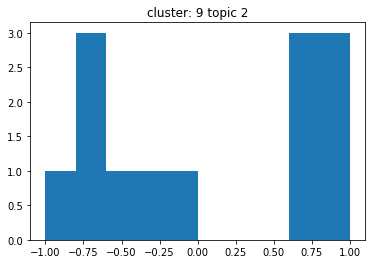

topic 2 [2017, 2018, 2019]


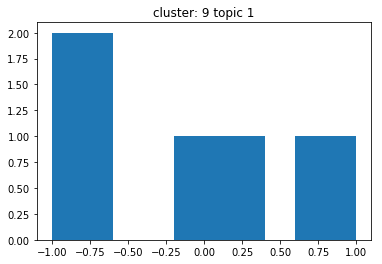

topic 1 [2017, 2018, 2019]


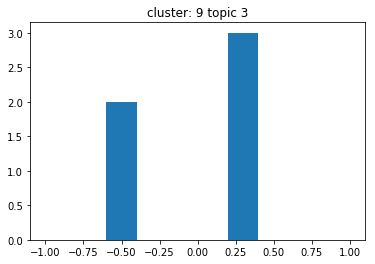

topic 3 [2018, 2019]
cluster  6  lunghezza  64
NUMBER OF TOPICS FOR CLUSTER  6  :  3
2019    34
2018    17
2017    13
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3
[8, 9, 10, 11]
numero di settimane in cluster 4


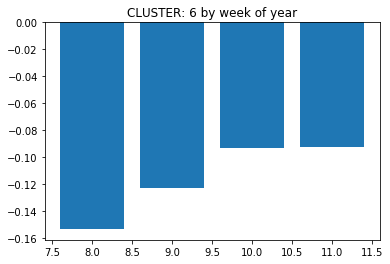

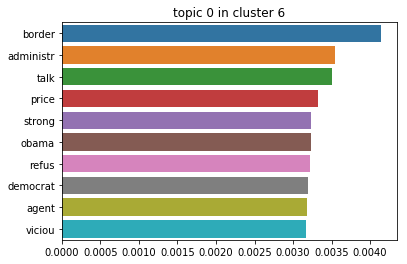

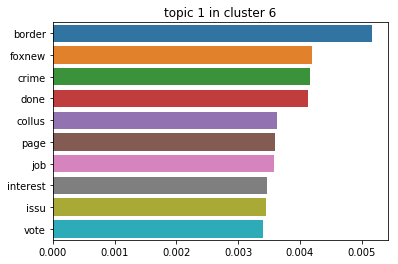

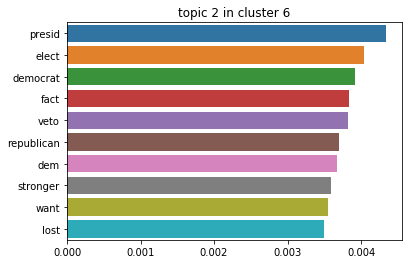

topics_count [27, 20, 17]


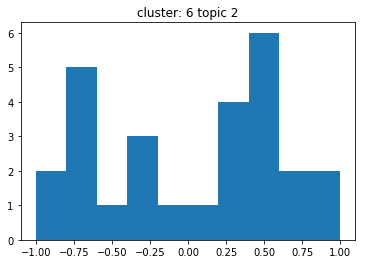

topic 2 [2017, 2018, 2019]


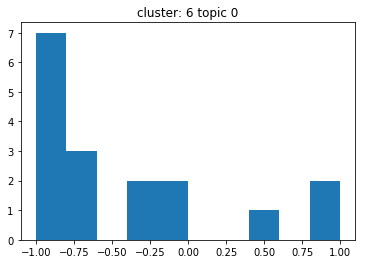

topic 0 [2017, 2018, 2019]


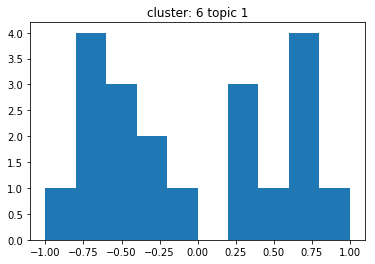

topic 1 [2017, 2018, 2019]
cluster  5  lunghezza  27
NUMBER OF TOPICS FOR CLUSTER  5  :  1
2018    15
2017     7
2019     5
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3
[12, 13, 14]
numero di settimane in cluster 3


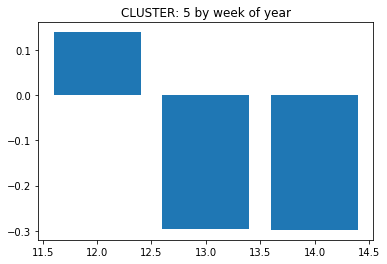

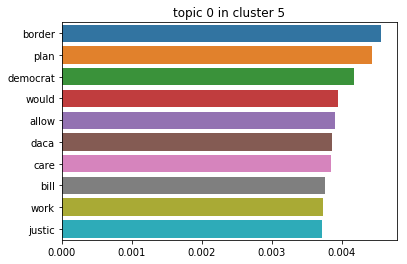

topics_count [27]


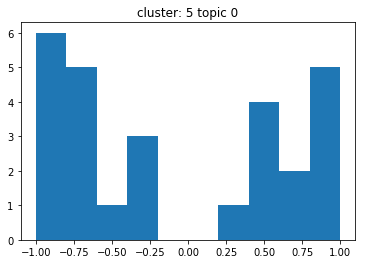

topic 0 [2017, 2018, 2019]
cluster  7  lunghezza  20
NUMBER OF TOPICS FOR CLUSTER  7  :  1
2018    11
2017     9
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[15, 16, 17]
numero di settimane in cluster 3


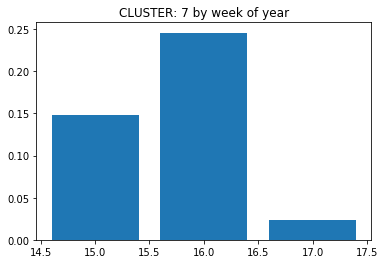

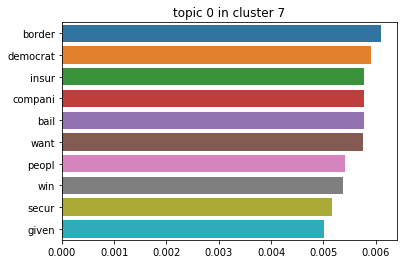

topics_count [20]


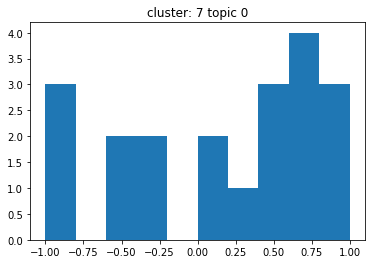

topic 0 [2017, 2018]
cluster  14  lunghezza  16
NUMBER OF TOPICS FOR CLUSTER  14  :  1
2018    9
2017    7
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[18, 19]
numero di settimane in cluster 2


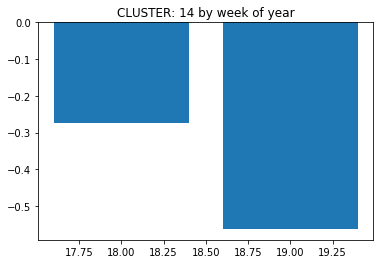

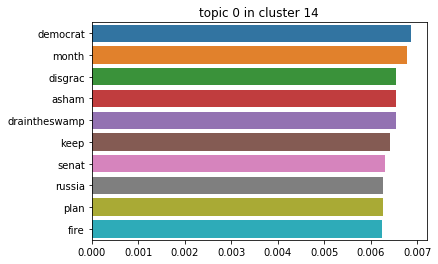

topics_count [16]


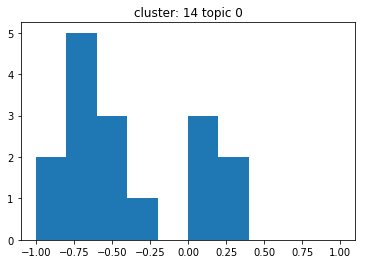

topic 0 [2017, 2018]
cluster  1  lunghezza  54
NUMBER OF TOPICS FOR CLUSTER  1  :  5
2018    46
2017     8
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[20, 22, 23, 21, 24]
numero di settimane in cluster 5


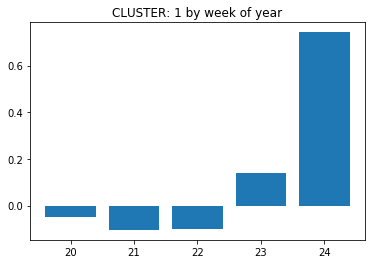

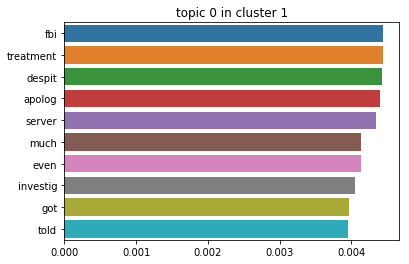

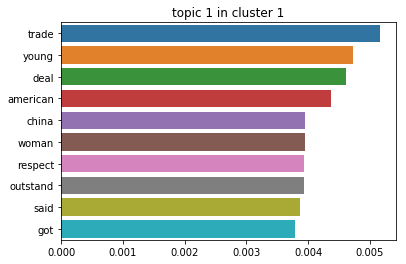

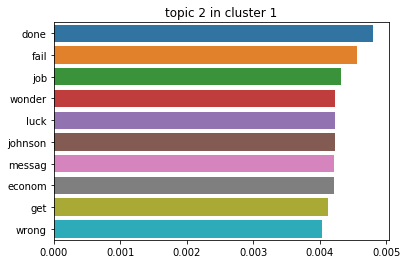

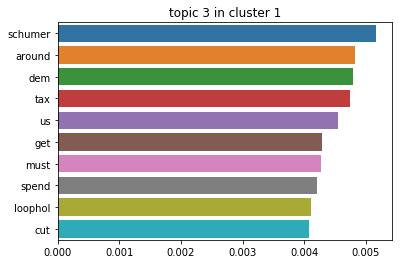

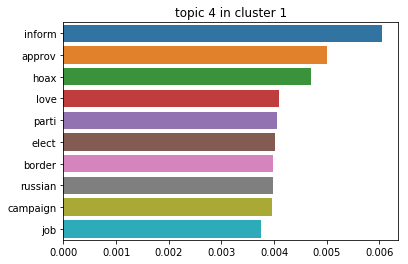

topics_count [12, 12, 10, 10, 10]


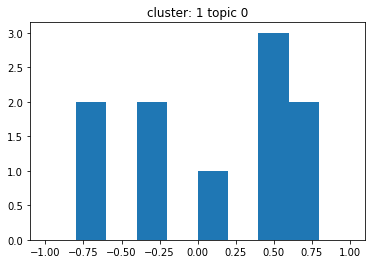

topic 0 [2017, 2018]


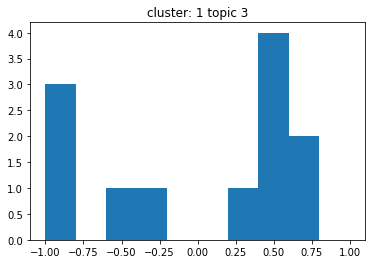

topic 3 [2017, 2018]


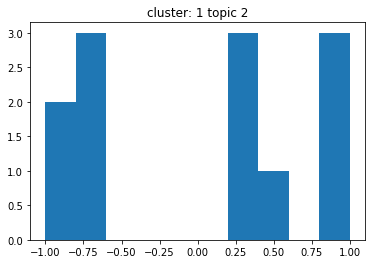

topic 2 [2017, 2018]


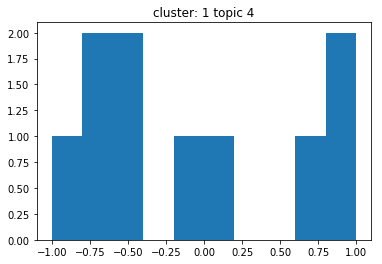

topic 4 [2017, 2018]


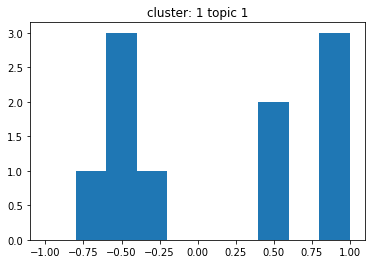

topic 1 [2017, 2018]
cluster  4  lunghezza  74
NUMBER OF TOPICS FOR CLUSTER  4  :  4
2018    48
2017    26
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[24, 25, 26, 27, 28]
numero di settimane in cluster 5


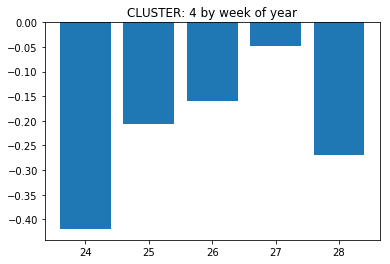

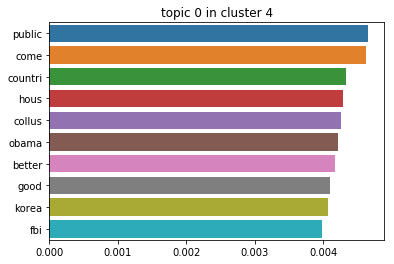

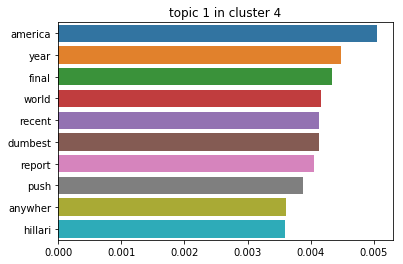

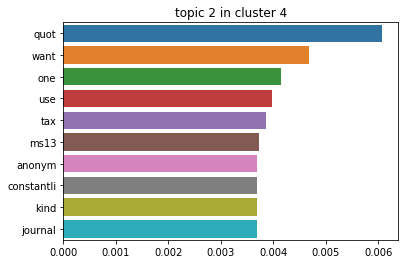

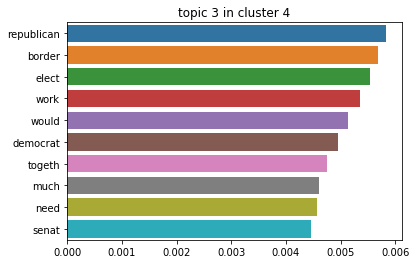

topics_count [27, 25, 11, 11]


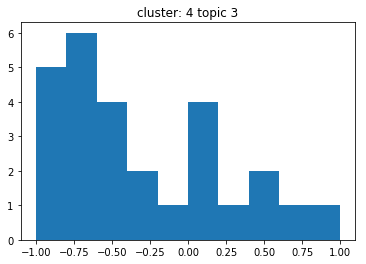

topic 3 [2017, 2018]


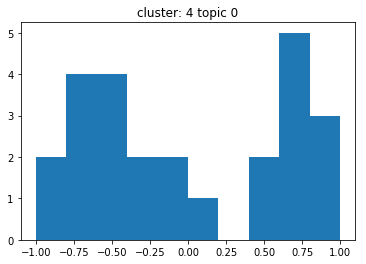

topic 0 [2017, 2018]


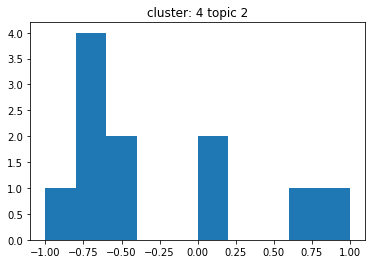

topic 2 [2017, 2018]


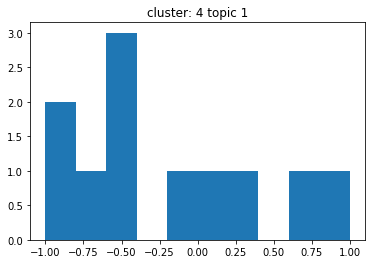

topic 1 [2017, 2018]
cluster  12  lunghezza  36
NUMBER OF TOPICS FOR CLUSTER  12  :  3
2018    25
2017    11
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[29, 30]
numero di settimane in cluster 2


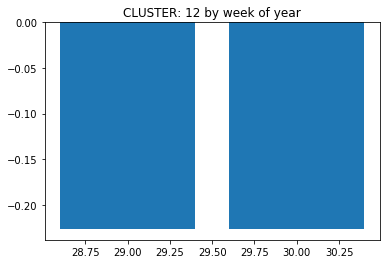

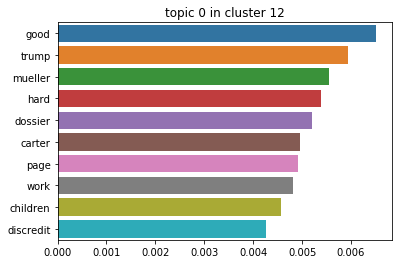

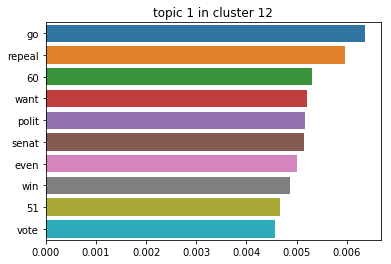

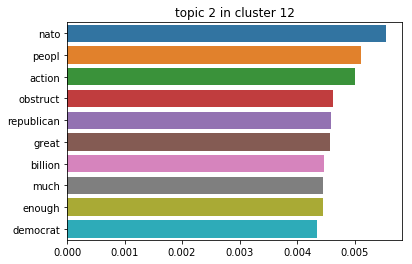

topics_count [17, 11, 8]


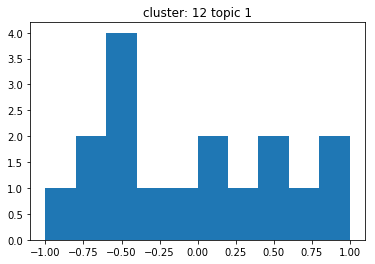

topic 1 [2017, 2018]


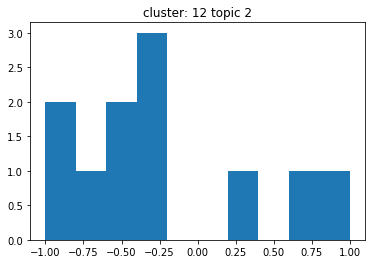

topic 2 [2017, 2018]


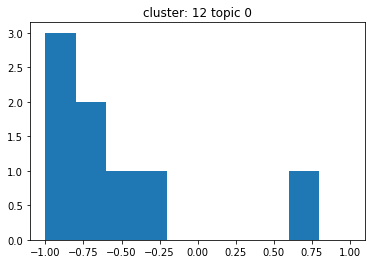

topic 0 [2018]
cluster  3  lunghezza  50
NUMBER OF TOPICS FOR CLUSTER  3  :  6
2018    33
2017    17
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[31, 32, 33, 34, 35]
numero di settimane in cluster 5


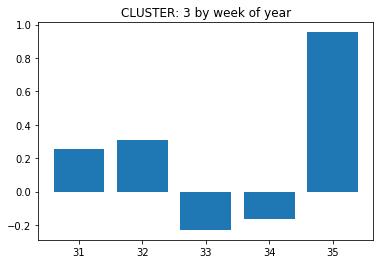

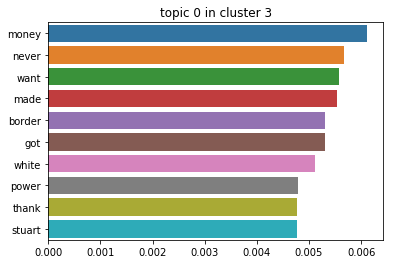

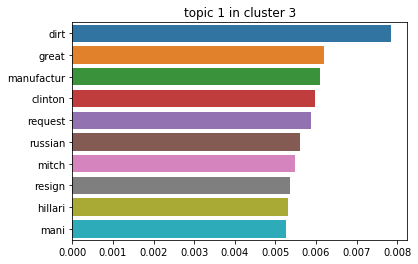

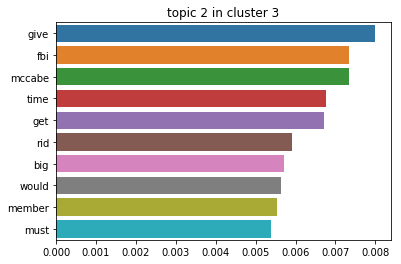

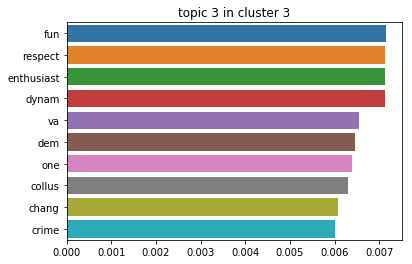

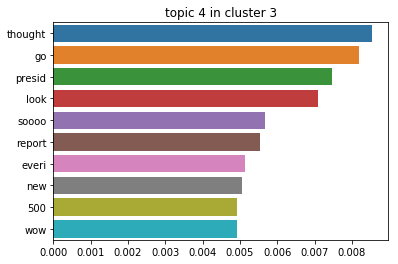

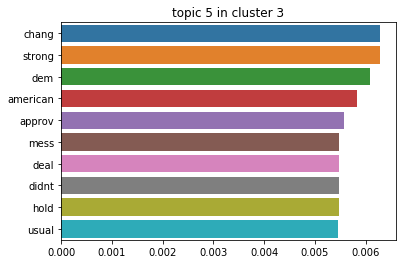

topics_count [14, 12, 7, 7, 6, 4]


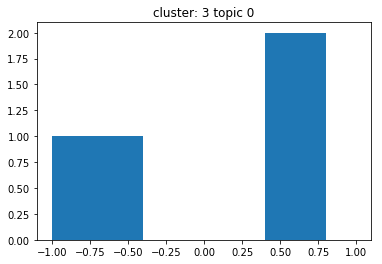

topic 0 [2017, 2018]


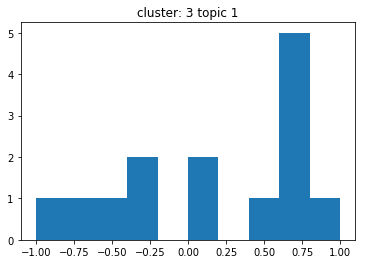

topic 1 [2017, 2018]


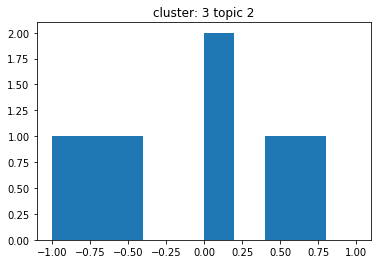

topic 2 [2017, 2018]


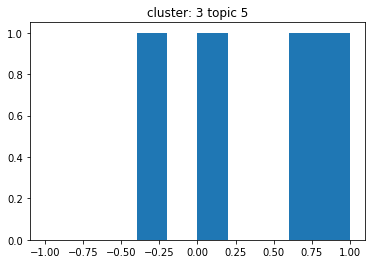

topic 5 [2017, 2018]


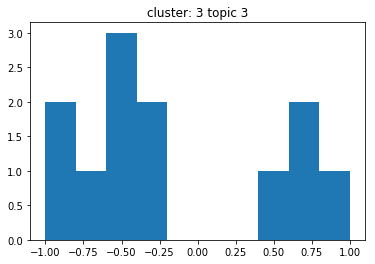

topic 3 [2017, 2018]


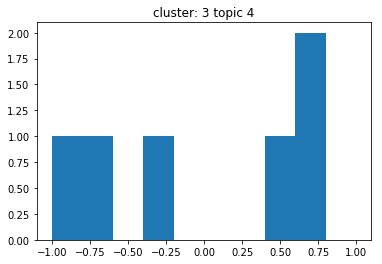

topic 4 [2017, 2018]
cluster  0  lunghezza  50
NUMBER OF TOPICS FOR CLUSTER  0  :  3
2018    37
2017    13
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[35, 36, 37, 38, 39]
numero di settimane in cluster 5


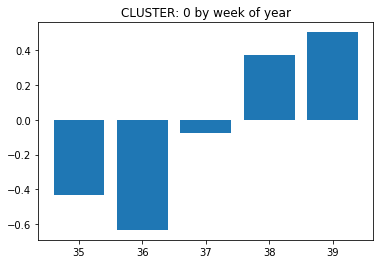

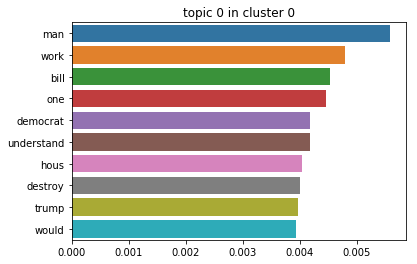

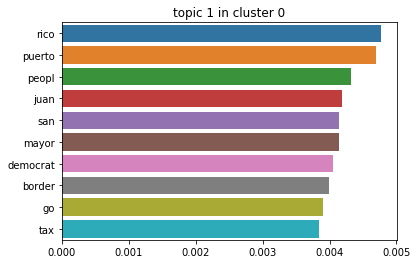

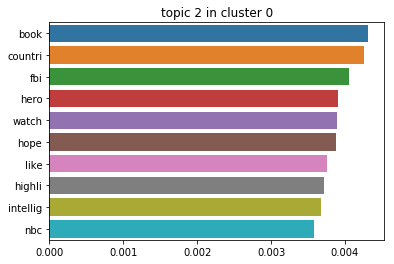

topics_count [21, 16, 13]


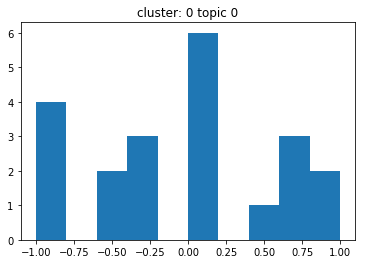

topic 0 [2017, 2018]


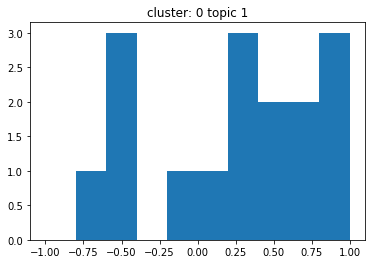

topic 1 [2017, 2018]


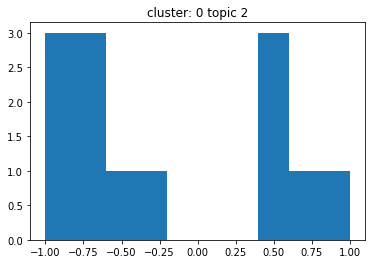

topic 2 [2017, 2018]
cluster  8  lunghezza  44
NUMBER OF TOPICS FOR CLUSTER  8  :  2
2017    24
2018    20
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[40, 41, 42, 43]
numero di settimane in cluster 4


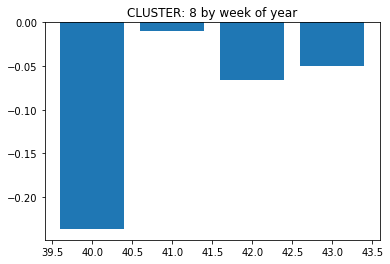

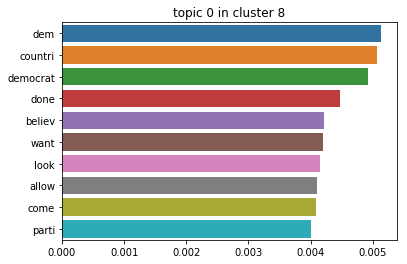

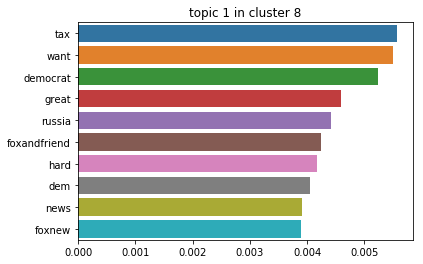

topics_count [24, 20]


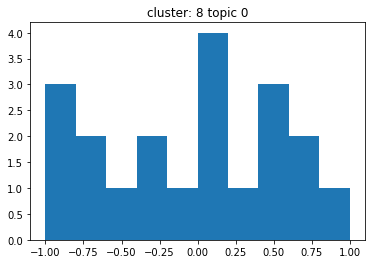

topic 0 [2017, 2018]


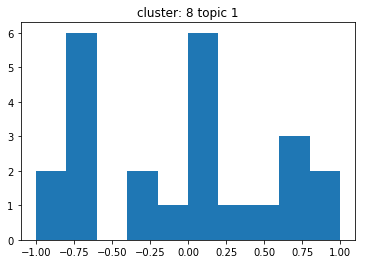

topic 1 [2017, 2018]
cluster  2  lunghezza  45
NUMBER OF TOPICS FOR CLUSTER  2  :  3
2018    27
2017    18
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[44, 45, 46, 47]
numero di settimane in cluster 4


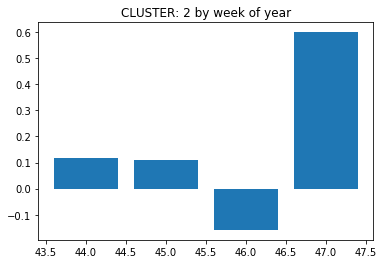

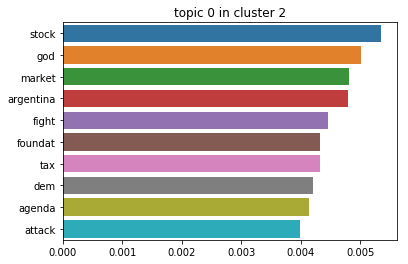

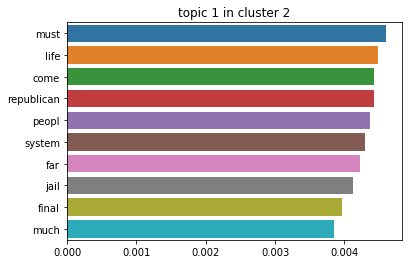

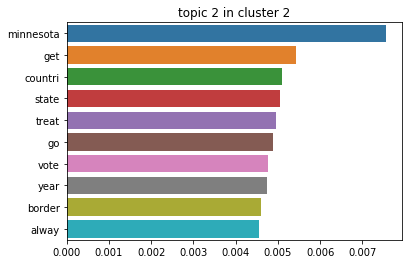

topics_count [17, 15, 13]


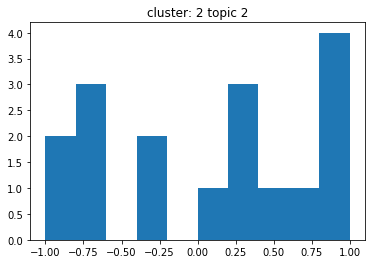

topic 2 [2017, 2018]


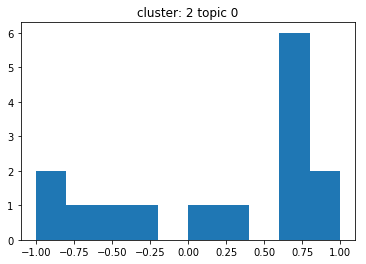

topic 0 [2017, 2018]


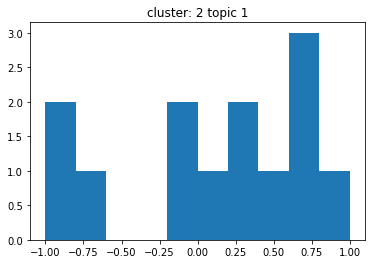

topic 1 [2017, 2018]
cluster  13  lunghezza  20
NUMBER OF TOPICS FOR CLUSTER  13  :  1
2018    12
2017     8
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[47, 48, 49]
numero di settimane in cluster 3


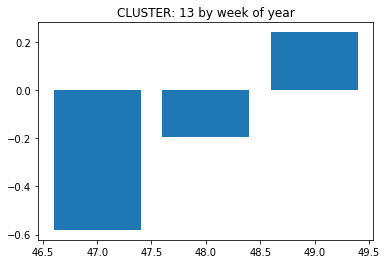

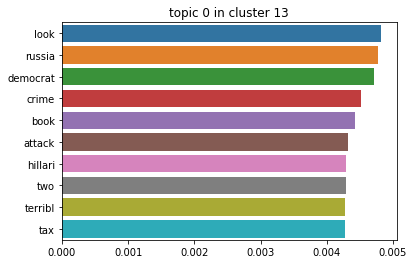

topics_count [20]


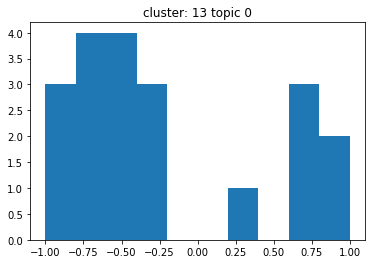

topic 0 [2017, 2018]
cluster  11  lunghezza  44
NUMBER OF TOPICS FOR CLUSTER  11  :  5
2018    33
2017    11
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2
[50, 51, 52]
numero di settimane in cluster 3


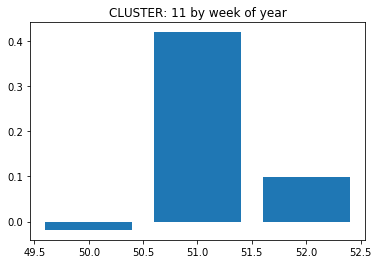

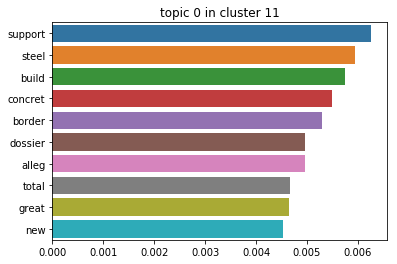

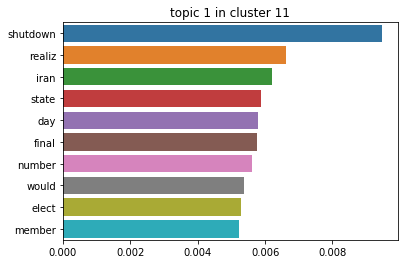

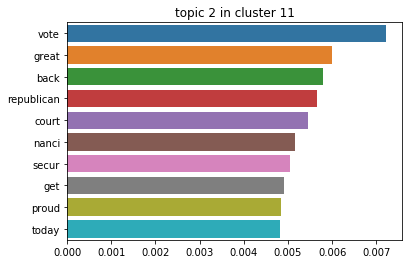

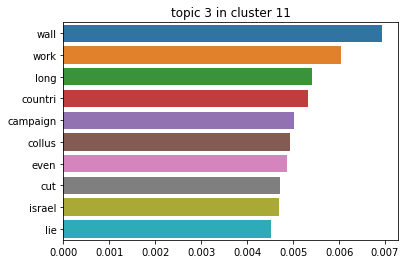

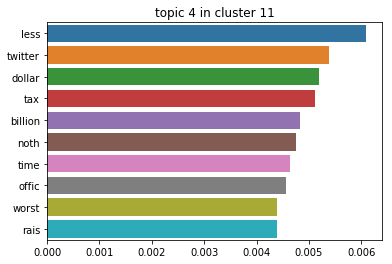

topics_count [11, 10, 9, 8, 6]


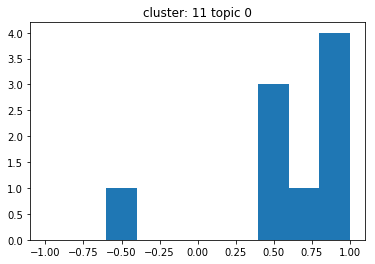

topic 0 [2017, 2018]


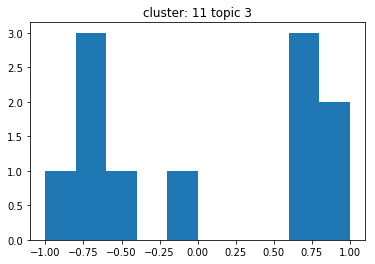

topic 3 [2017, 2018]


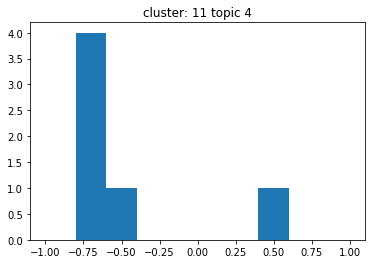

topic 4 [2017, 2018]


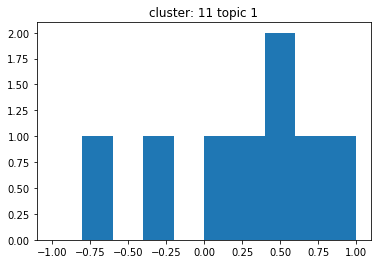

topic 1 [2017, 2018]


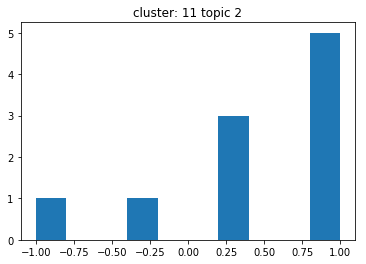

topic 2 [2018]


In [19]:
for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))
        
        from gensim.corpora.dictionary import Dictionary

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        
        common_dictionary = Dictionary(corp)
        common_corpus = [common_dictionary.doc2bow(text) for text in corp]
        tfidf = TfidfModel(common_corpus)
        tfidf_corpus = tfidf[common_corpus]


        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)

        lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary)

        
        #plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        #plt.title("Sentiment score for cluster: " + str(cluster))
        #plt.show()
        print(d1["date_year"].value_counts())
        print(d1["date_year"].unique().tolist())
        print("anni nel cluster ", len(d1["date_year"].unique().tolist()))
        print(d1["week_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster) + " by week of year")
        plt.bar(time.index, time )
        plt.show()

        topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False,log=True)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.001:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            sns.barplot(x=weights, y=words)
            plt.show()        
        topicColumn = []
        for el in tfidf_corpus:
            vector = lda.get_document_topics(el)
            #get topic
            m = max(y for (x,y) in vector)
            ind = [x for x, y in enumerate(vector) if y[1] == m][0]
            #print(ind,m)
            if ind not in topicList:
                topicList[ind] = 1
            else: 
                topicList[ind] += 1
            topicColumn.append(ind)
        d1["topic"] = topicColumn
        #print(topicColumn)
        print("topics_count",d1["topic"].value_counts().tolist())
        
        for t in d1["topic"].unique():
            d2 = d1[d1["topic"] == t]
            plt.title("cluster: " + str(cluster) + " topic " + str(t))
            plt.hist(d2["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
            plt.show()
            print("topic "+ str(t), d2["date_year"].unique().tolist())
        
        
        